In [1]:
#please put this notebook in models/reaserch/object_detection


#please make sure you have ipywidgets installed

#please make sure your env has these packeges
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models
    

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import random

from tqdm.notebook import tqdm
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#this method will download the model if it's not found
#or will load the model if found

def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

#The method where actual detection happen
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                     for key,value in output_dict.items()}

    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                      output_dict['detection_masks'], output_dict['detection_boxes'],
                       image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                               tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

#prepare the image take the detection output and display result

#parametrs:
#model: the model object
#TEST_IMAGE_PATH: a list of all the images paths which you want to perform object detection
#querry: the user querry in a form of string. one object(e.g:'dog'), n-objects(e.g:'cat, car, person')
#boxes: boolean value set to True to show boundry boxes
#result: number of retrived images. (num=5, after the model retrive 5 images the search will be stoped)
#sfuffle: boolean value set to True to shuffle TEST_IMAGE_PATH
#show_path: boolean value set to True to print the path of the retrived image

def search_engineV2(model, TEST_IMAGE_PATHS, querry, boxes=False, result_num=5, shuffle=False, show_path=False):
    #divide the querry based on',' the clean it
    querry_list=querry.split(',')
    for i in range(len(querry_list)):
        querry_list[i]=querry_list[i].strip().lower()
        
    num=0#store number of found images(results)
    TEST_IMAGE_PATHS_COPY=TEST_IMAGE_PATHS
    
    if shuffle:
        random.shuffle(TEST_IMAGE_PATHS_COPY)
        
    #start searching the database
    for image_path in tqdm(TEST_IMAGE_PATHS_COPY):
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = np.array(Image.open(image_path))
    
        try:
            # Actual detection.
            output_dict = run_inference_for_single_image(model, image_np)
        except Exception as e:
            print("problem with", image_path)
            continue
            
    
        #get the indexes of the objects which has a conf of 50% or hihger
        indexes=[]
        for i in range(len(output_dict['detection_scores'])):
            if output_dict['detection_scores'][i] >= 0.5:
                indexes.append(i)
    
        #get the meaning of each class from the map_label
        classes=[]
        for i in indexes:
        
            classes.append(category_index[ output_dict['detection_classes'][i] ]['name'].lower())#path_label start index from 1
    
    
        #check if all querry object is detected in the picture
        match=True
        for que in querry_list:
            if que not in classes:
                match=False
                break
            
    
        if match:
            print('[',num,']', end=' ')
            if show_path:
                print(image_path)
            
            if boxes:
                box_list=[]
                score_list=[]
                class_list=[]
                
                #get indexes of the desired objects
                for i in querry_list:
                    
                    box_list.append(output_dict['detection_boxes'][classes.index(i)])
                    class_list.append(output_dict['detection_classes'][classes.index(i)])
                    score_list.append(output_dict['detection_scores'][classes.index(i)])
                
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.array(box_list),
                  np.array(class_list),
                  np.array(score_list),
                  category_index,
                  instance_masks=output_dict.get('detection_masks_reframed', None),
                  use_normalized_coordinates=True,
                  line_thickness=8)
                
                
            display(Image.fromarray(image_np))
            num+=1
            if num == result_num:
                break
            
    print('Search ended')
    
    
    
#get first 1000 images from the orignal dataset
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:1000]


#load first model

model_name = 'mask_rcnn_resnet101_atrous_coco_2018_01_28'
detection_model = load_model(model_name)

661905408/661899639 [==============================] - 306s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [2]:
#shuffle the subset before testing
random.shuffle(TEST_IMAGE_PATHS)

run time = 32:07
images = 25

problem with models\research\object_detection\test_images\000000002587.jpg
problem with models\research\object_detection\test_images\000000096960.jpg
problem with models\research\object_detection\test_images\000000100238.jpg
problem with models\research\object_detection\test_images\000000019109.jpg
problem with models\research\object_detection\test_images\000000038118.jpg
problem with models\research\object_detection\test_images\000000007888.jpg
problem with models\research\object_detection\test_images\000000080932.jpg
problem with models\research\object_detection\test_images\000000090062.jpg
problem with models\research\object_detection\test_images\000000107226.jpg
problem with models\research\object_detection\test_images\000000104612.jpg
problem with models\research\object_detection\test_images\000000005503.jpg
problem with models\research\object_detection\test_images\000000062808.jpg
problem with models\research\object_detection\test_images\000000081766.jpg
problem with models\resea

problem with models\research\object_detection\test_images\000000112378.jpg
problem with models\research\object_detection\test_images\000000087476.jpg
problem with models\research\object_detection\test_images\000000007511.jpg
problem with models\research\object_detection\test_images\000000008021.jpg
problem with models\research\object_detection\test_images\000000032610.jpg
problem with models\research\object_detection\test_images\000000089045.jpg
problem with models\research\object_detection\test_images\000000109798.jpg
problem with models\research\object_detection\test_images\000000033854.jpg
problem with models\research\object_detection\test_images\000000011122.jpg
problem with models\research\object_detection\test_images\000000074200.jpg
problem with models\research\object_detection\test_images\000000013004.jpg
problem with models\research\object_detection\test_images\000000110638.jpg
problem with models\research\object_detection\test_images\000000080057.jpg
problem with models\resea

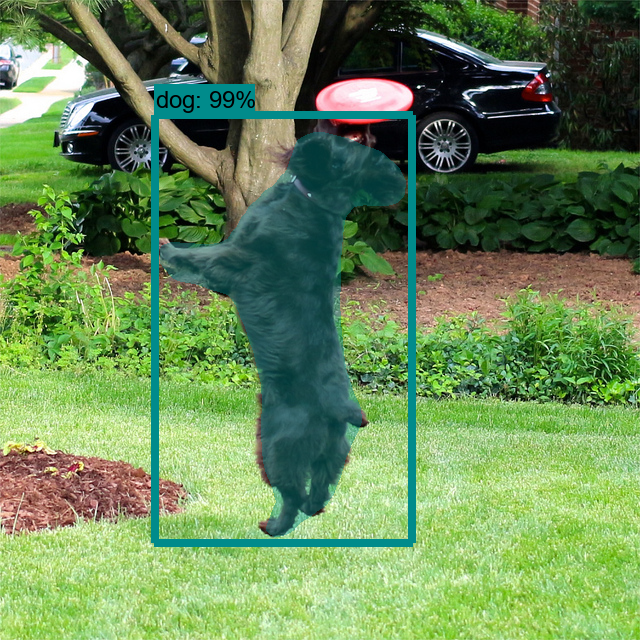

problem with models\research\object_detection\test_images\000000025228.jpg
problem with models\research\object_detection\test_images\000000093261.jpg
problem with models\research\object_detection\test_images\000000085576.jpg
problem with models\research\object_detection\test_images\000000086220.jpg
problem with models\research\object_detection\test_images\000000096493.jpg
problem with models\research\object_detection\test_images\000000020553.jpg
problem with models\research\object_detection\test_images\000000104455.jpg
problem with models\research\object_detection\test_images\000000025593.jpg
problem with models\research\object_detection\test_images\000000057150.jpg
problem with models\research\object_detection\test_images\000000095155.jpg
problem with models\research\object_detection\test_images\000000042889.jpg
problem with models\research\object_detection\test_images\000000001425.jpg
problem with models\research\object_detection\test_images\000000032811.jpg
problem with models\resea

problem with models\research\object_detection\test_images\000000043737.jpg
problem with models\research\object_detection\test_images\000000012576.jpg
problem with models\research\object_detection\test_images\000000066635.jpg
problem with models\research\object_detection\test_images\000000030494.jpg
problem with models\research\object_detection\test_images\000000025986.jpg
problem with models\research\object_detection\test_images\000000104603.jpg
problem with models\research\object_detection\test_images\000000044699.jpg
problem with models\research\object_detection\test_images\000000088462.jpg
problem with models\research\object_detection\test_images\000000028449.jpg
problem with models\research\object_detection\test_images\000000013774.jpg
problem with models\research\object_detection\test_images\000000026465.jpg
problem with models\research\object_detection\test_images\000000088345.jpg
problem with models\research\object_detection\test_images\000000051938.jpg
problem with models\resea

KeyboardInterrupt: 

In [3]:
search_engineV2(detection_model, TEST_IMAGE_PATHS, 'dog', show_path=True, result_num=len(TEST_IMAGE_PATHS), boxes=True)

In [ ]:
#shuffle the subset before testing
random.shuffle(TEST_IMAGE_PATHS)

run time = 32:07
images = 25

In [ ]:
search_engineV2(detection_model, TEST_IMAGE_PATHS, 'car', show_path=True, result_num=len(TEST_IMAGE_PATHS), boxes=True)

In [ ]:
#shuffle the subset before testing
random.shuffle(TEST_IMAGE_PATHS)

run time = 32:07
images = 25

In [ ]:
search_engineV2(detection_model, TEST_IMAGE_PATHS, 'bus, person', show_path=True, result_num=len(TEST_IMAGE_PATHS), boxes=True)